In [3]:
from opendbc.car import structs
from opendbc.car.hyundai.values import CAR, HyundaiFlags
from opendbc.car.hyundai.fingerprints import FW_VERSIONS

TEST_PLATFORMS = set(CAR.with_flags(HyundaiFlags.CANFD)) & set(CAR.with_flags(HyundaiFlags.CANFD_ANGLE_STEERING))  # CAN-FD electric vehicles only
#TEST_PLATFORMS = set(CAR.with_flags(HyundaiFlags.CANFD)) - set(CAR.with_flags(HyundaiFlags.EV))  # CAN-FD hybrid and ICE vehicles only

print(f"Found {len(TEST_PLATFORMS)} qualifying vehicles:")
for platform in TEST_PLATFORMS:
  print(f"  {platform}")

Found 2 qualifying vehicles:
  GENESIS_GV80_2025
  HYUNDAI_IONIQ_5_PE


In [4]:
TEST_SEGMENTS = ['e1107f9d04dfb1e2/00000096--02ecca61a6']


In [5]:
import copy
import matplotlib.pyplot as plt
import numpy as np
from opendbc.can.parser import CANParser
from opendbc.car.hyundai.values import DBC
from opendbc.car.hyundai.hyundaicanfd import CanBus
from openpilot.selfdrive.pandad import can_capnp_to_list
from openpilot.tools.lib.logreader import LogReader

# Keep both messages we're interested in
message_names = ["LKAS_ALT", "LFA_ALT"]

# You need to define this variable if it's not already defined
# TEST_SEGMENTS = ["path/to/segment1", "path/to/segment2"]
# And platform variable if not defined
# platform = "CANFD"

# Select one segment for testing/debugging
segment = TEST_SEGMENTS[0]  # Change index as needed

In [6]:
# Load the segment
lr = LogReader(segment)
CP = lr.first("carParams")
if CP is None:
    print(f"No carParams found in segment {segment}")
else:
    print(f"Analyzing segment {segment} for {CP.carFingerprint}")

    # Get CAN messages
    can_msgs = [msg for msg in lr if msg.which() == "can"]
    print(f"Found {len(can_msgs)} CAN messages")
    
    # Setup parser
    parser_messages = []
    for name in message_names:
        parser_messages.append((name, 0))
    
    try:
        cp = CANParser(DBC[platform]["pt"], parser_messages, CanBus(CP).ECAN)
        print("Parser initialized successfully")
    except Exception as e:
        print(f"Error initializing parser: {e}")

Analyzing segment e1107f9d04dfb1e2/00000096--02ecca61a6 for HYUNDAI_IONIQ_5_PE
Found 72009 CAN messages
Parser initialized successfully


In [17]:
parser_messages = [("LKAS_ALT",0),("LFA_ALT",0)]
# Reset parser
cp = CANParser(DBC[platform]["pt"], parser_messages, CanBus(CP).ECAN)

# Check a single message
example_idx = 0
a = set()
while example_idx < len(can_msgs):
    try:
        cp.update_strings(can_capnp_to_list([can_msgs[example_idx].as_builder().to_bytes()]))
        
        #Print all available signals in both messages
        #print("Available signals:")
        #if "LKAS_ALT" in cpacan.vl:
        #    print("  LKAS_ALT:", cpacan.vl["LKAS_ALT"])
        #if "LFA_ALT" in cp.vl:
        #    print("  LFA_ALT:", cp.vl["LFA_ALT"])
        
        # Found at least one message with data
        #if "LKAS_ALT" in cp.vl or "LFA_ALT" in cp.vl:
        #    break
        #if cp.vl["LFA_ALT"]["LKAS_ANGLE_MAX_TORQUE"]>0:
        #    a.add(cp.vl["LFA_ALT"]["LKAS_ANGLE_MAX_TORQUE"])
            #print("AAAA")
            #break
        if cp.vl["LFA_ALT"]["LKAS_ANGLE_ACTIVE"]>0:
            a.add(cp.vl["LFA_ALT"]["LKAS_ANGLE_ACTIVE"])
            #print("AAAA")
            #break
            
    except Exception as e:
        print(f"Error examining message {example_idx}: {e}")
    
    example_idx += 1
    

print(example_idx) # 72009
print(a)

72009
{1.0, 2.0}


In [26]:
# Reset parser
cp = CANParser(DBC[platform]["pt"], parser_messages, CanBus(CP).ECAN)

# Track timestamps and angle commands when active
timestamps = []
angle_cmds = []
active_flags = []  # For debugging
msg_indices = []   # Store original message indices for reference

# Process all CAN messages
for i, msg in enumerate(can_msgs):
    try:
        cp.update_strings(can_capnp_to_list([msg.as_builder().to_bytes()]))
        
        # Check if both required messages and signals are present
        if "LFA_ALT" in cp.vl and "LKAS_ALT" in cp.vl:
            if "LKAS_ANGLE_ACTIVE" in cp.vl["LFA_ALT"] and "LKAS_ANGLE_CMD" in cp.vl["LKAS_ALT"]:
                active_val = cp.vl["LFA_ALT"]["LKAS_ANGLE_ACTIVE"]
                active_flags.append(active_val)
                
                # Only collect data when active is 2
                if active_val == 2:
                    timestamps.append(msg.logMonoTime / 1e9)  # Convert to seconds
                    angle_cmds.append(cp.vl["LFA_ALT"]["LKAS_ANGLE_CMD"])
                    msg_indices.append(i)
    except Exception as e:
        if i % 1000 == 0:  # Only print errors occasionally to avoid flooding
            print(f"Error processing message {i}: {e}")

print(f"Total messages processed: {len(can_msgs)}")
print(f"LKAS_ANGLE_ACTIVE values encountered: {set(active_flags)}")
print(f"Active steering points collected: {len(timestamps)}")

Total messages processed: 72009
LKAS_ANGLE_ACTIVE values encountered: {1.0, 2.0}
Active steering points collected: 25502


In [28]:
# Find continuous active periods
active_periods = []
if msg_indices:
    # Start with the first active message
    current_period = [0, 0]
    
    for i in range(1, len(msg_indices)):
        # Check if consecutive in the original message sequence
        if msg_indices[i] == msg_indices[i-1] + 1:
            # Part of the same period
            current_period[1] = i
        else:
            # Gap in sequence, start new period
            active_periods.append(current_period)
            current_period = [i, i]
    
    # Add the last period
    active_periods.append(current_period)

print(f"Found {len(active_periods)} active steering periods")
for i, (start, end) in enumerate(active_periods):
    duration = timestamps[end] - timestamps[start]
    num_points = end - start + 1
    print(f"  Period {i+1}: {num_points} points over {duration:.2f}s")

Found 16 active steering periods
  Period 1: 886 points over 8.86s
  Period 2: 4292 points over 42.91s
  Period 3: 800 points over 7.99s
  Period 4: 199 points over 1.98s
  Period 5: 1284 points over 12.83s
  Period 6: 65 points over 0.64s
  Period 7: 1052 points over 10.52s
  Period 8: 655 points over 6.54s
  Period 9: 2315 points over 23.14s
  Period 10: 4405 points over 44.04s
  Period 11: 262 points over 2.61s
  Period 12: 2147 points over 21.47s
  Period 13: 1449 points over 14.48s
  Period 14: 2681 points over 26.80s
  Period 15: 2765 points over 27.64s
  Period 16: 245 points over 2.44s


Analysis of Period 2:
  Duration: 42.91s
  Points: 4292
  Angle range: -22.10 to 2.30
  Max absolute rate of change: 0.40 units/frame


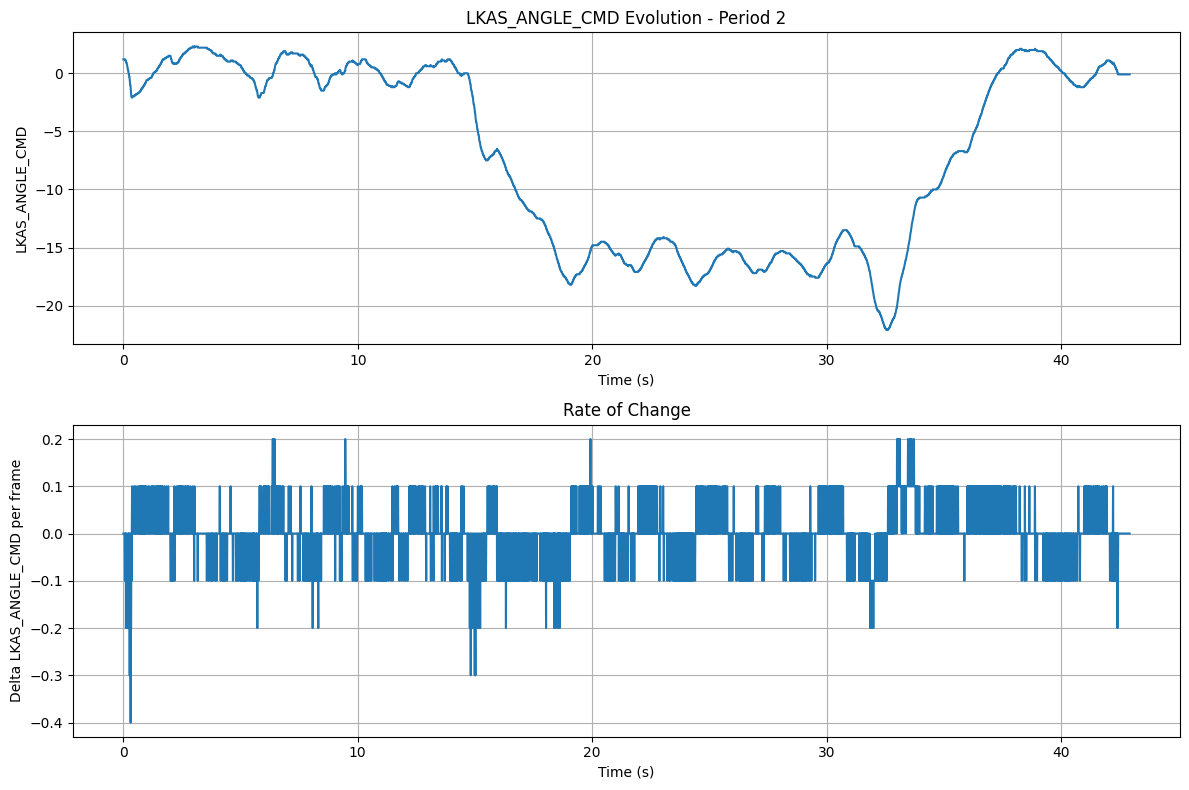

In [31]:
## Choose a period to analyze (if any exist)
if active_periods:
    # Find the period with the most points
    #longest_period_idx = max(range(len(active_periods)), 
    #                         key=lambda i: active_periods[i][1] - active_periods[i][0])
    longest_period_idx = 1
    
    start_idx, end_idx = active_periods[longest_period_idx]
    
    # Get data for this period
    period_timestamps = timestamps[start_idx:end_idx+1]
    period_angle_cmds = angle_cmds[start_idx:end_idx+1]
    
    # Normalize timestamps to start at 0
    norm_timestamps = [t - period_timestamps[0] for t in period_timestamps]
    
    # Calculate rate of change
    angle_cmd_diffs = np.diff(period_angle_cmds)
    
    # Print statistics
    print(f"Analysis of Period {longest_period_idx+1}:")
    print(f"  Duration: {period_timestamps[-1] - period_timestamps[0]:.2f}s")
    print(f"  Points: {len(period_angle_cmds)}")
    print(f"  Angle range: {min(period_angle_cmds):.2f} to {max(period_angle_cmds):.2f}")
    print(f"  Max absolute rate of change: {max(abs(angle_cmd_diffs)):.2f} units/frame")
    
    # Plot the angle command evolution
    plt.figure(figsize=(12, 8))
    
    # Plot angle commands
    plt.subplot(2, 1, 1)
    plt.plot(norm_timestamps, period_angle_cmds)
    plt.title(f"LKAS_ANGLE_CMD Evolution - Period {longest_period_idx+1}")
    plt.xlabel("Time (s)")
    plt.ylabel("LKAS_ANGLE_CMD")
    plt.grid(True)
    
    # Plot rate of change
    plt.subplot(2, 1, 2)
    plt.plot(norm_timestamps[1:], angle_cmd_diffs)
    plt.title("Rate of Change")
    plt.xlabel("Time (s)")
    plt.ylabel("Delta LKAS_ANGLE_CMD per frame")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("No active periods found to analyze")

Analysis of Period 1:
  Duration: 8.86s
  Points: 886
  Angle range: -1.80 to 7.10
  Max absolute rate of change: 0.40 units/frame

Analysis of Period 2:
  Duration: 42.91s
  Points: 4292
  Angle range: -22.10 to 2.30
  Max absolute rate of change: 0.40 units/frame

Analysis of Period 3:
  Duration: 7.99s
  Points: 800
  Angle range: -12.60 to 6.50
  Max absolute rate of change: 0.30 units/frame

Analysis of Period 4:
  Duration: 1.98s
  Points: 199
  Angle range: 0.00 to 1.60
  Max absolute rate of change: 0.10 units/frame

Analysis of Period 5:
  Duration: 12.83s
  Points: 1284
  Angle range: -6.20 to 4.30
  Max absolute rate of change: 0.30 units/frame

Analysis of Period 6:
  Duration: 0.64s
  Points: 65
  Angle range: -1.80 to -1.00
  Max absolute rate of change: 0.10 units/frame

Analysis of Period 7:
  Duration: 10.52s
  Points: 1052
  Angle range: -38.80 to 1.80
  Max absolute rate of change: 0.40 units/frame

Analysis of Period 8:
  Duration: 6.54s
  Points: 655
  Angle range:

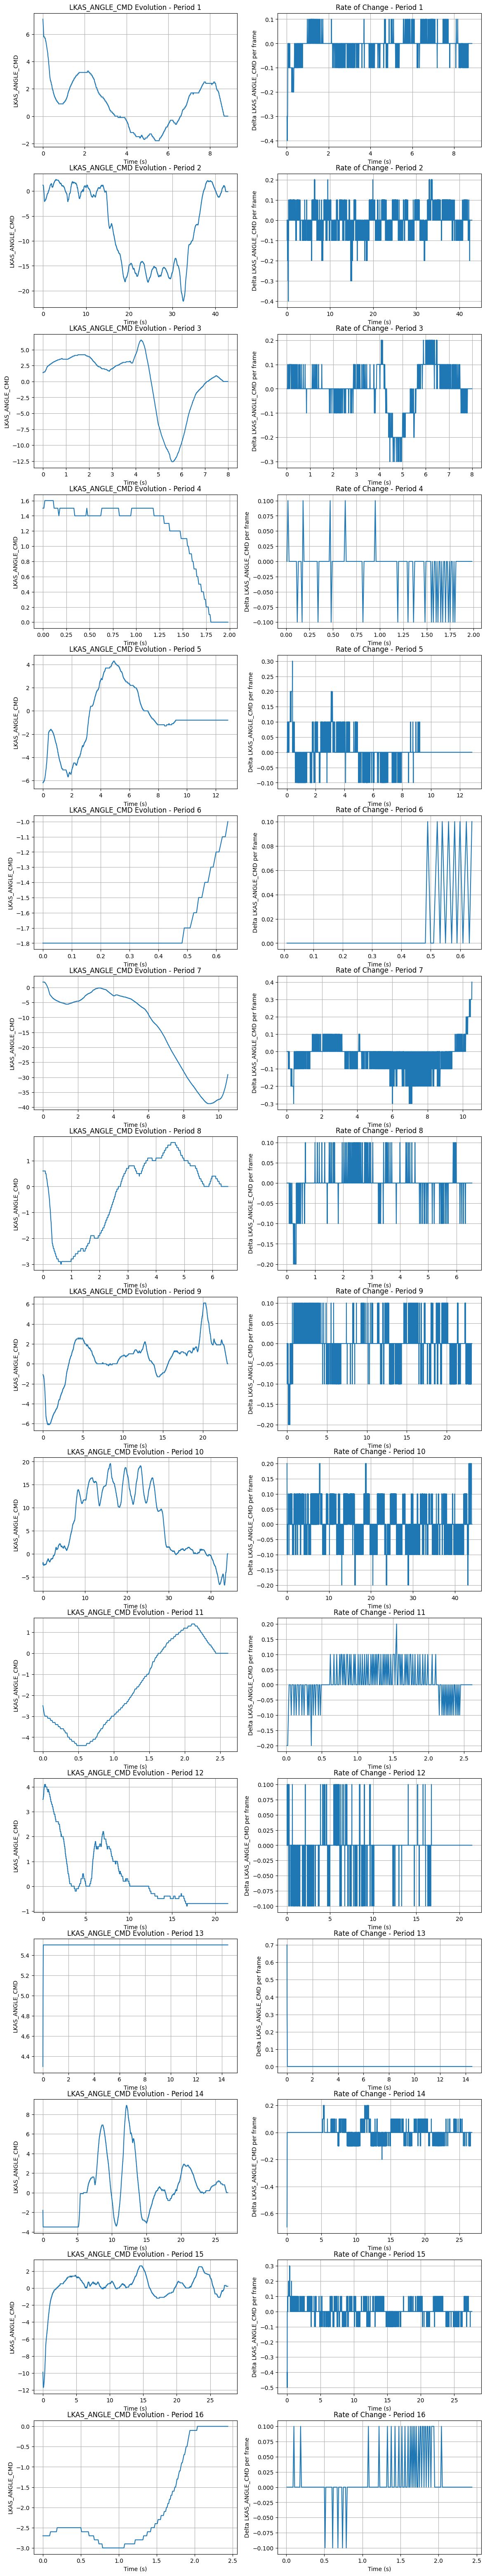

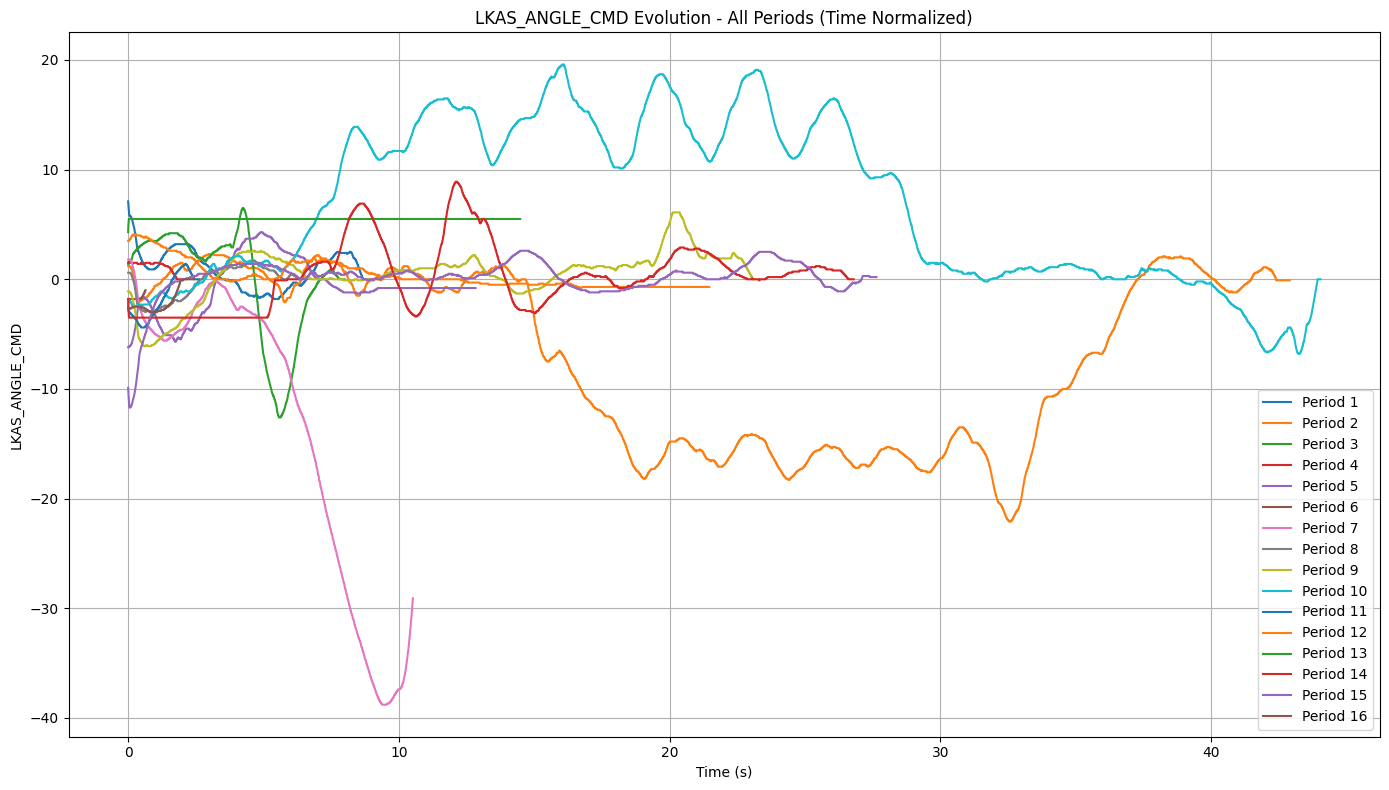

In [32]:
# Analyze all active periods
if active_periods:
    # Initialize variables to track overall statistics
    all_max_rates = []
    
    # Create a figure with subplots for all periods
    num_periods = len(active_periods)
    fig, axes = plt.subplots(num_periods, 2, figsize=(14, 5*num_periods))
    
    # If there's only one period, make axes indexable as a 2D array
    if num_periods == 1:
        axes = np.array([axes])
    
    # Process each active period
    for i, (start_idx, end_idx) in enumerate(active_periods):
        # Get data for this period
        period_timestamps = timestamps[start_idx:end_idx+1]
        period_angle_cmds = angle_cmds[start_idx:end_idx+1]
        
        # Normalize timestamps to start at 0
        norm_timestamps = [t - period_timestamps[0] for t in period_timestamps]
        
        # Calculate rate of change
        angle_cmd_diffs = np.diff(period_angle_cmds)
        max_rate = max(abs(angle_cmd_diffs))
        all_max_rates.append(max_rate)
        
        # Print statistics for this period
        print(f"Analysis of Period {i+1}:")
        print(f"  Duration: {period_timestamps[-1] - period_timestamps[0]:.2f}s")
        print(f"  Points: {len(period_angle_cmds)}")
        print(f"  Angle range: {min(period_angle_cmds):.2f} to {max(period_angle_cmds):.2f}")
        print(f"  Max absolute rate of change: {max_rate:.2f} units/frame")
        print()
        
        # Plot angle commands
        axes[i, 0].plot(norm_timestamps, period_angle_cmds)
        axes[i, 0].set_title(f"LKAS_ANGLE_CMD Evolution - Period {i+1}")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("LKAS_ANGLE_CMD")
        axes[i, 0].grid(True)
        
        # Plot rate of change
        axes[i, 1].plot(norm_timestamps[1:], angle_cmd_diffs)
        axes[i, 1].set_title(f"Rate of Change - Period {i+1}")
        axes[i, 1].set_xlabel("Time (s)")
        axes[i, 1].set_ylabel("Delta LKAS_ANGLE_CMD per frame")
        axes[i, 1].grid(True)
    
    # Print average maximum rate of change
    avg_max_rate = sum(all_max_rates) / len(all_max_rates)
    print(f"Average maximum rate of change across all periods: {avg_max_rate:.2f} units/frame")
    
    # Add a summary section with all periods on one plot
    plt.figure(figsize=(14, 8))
    
    # Plot all periods with different colors
    for i, (start_idx, end_idx) in enumerate(active_periods):
        period_timestamps = timestamps[start_idx:end_idx+1]
        period_angle_cmds = angle_cmds[start_idx:end_idx+1]
        norm_timestamps = [t - period_timestamps[0] for t in period_timestamps]
        
        plt.plot(norm_timestamps, period_angle_cmds, label=f"Period {i+1}")
    
    plt.title("LKAS_ANGLE_CMD Evolution - All Periods (Time Normalized)")
    plt.xlabel("Time (s)")
    plt.ylabel("LKAS_ANGLE_CMD")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Also display the original figure with individual period plots
    fig.tight_layout()
    plt.show()
else:
    print("No active periods found to analyze")

Analysis of Period 1:
  Duration: 8.86s
  Points: 886
  Angle range: -1.80 to 7.10
  Max absolute rate of change: 0.40 degrees/frame
  Max absolute rate of change: 38.82 degrees/second
  Avg time from min to max: 0.48s
  Avg rate from min to max: 2.01 degrees/second
  Max rate from min to max: 2.98 degrees/second

Analysis of Period 2:
  Duration: 42.91s
  Points: 4292
  Angle range: -22.10 to 2.30
  Max absolute rate of change: 0.40 degrees/frame
  Max absolute rate of change: 35.88 degrees/second
  Avg time from min to max: 0.51s
  Avg rate from min to max: 2.26 degrees/second
  Max rate from min to max: 4.89 degrees/second

Analysis of Period 3:
  Duration: 7.99s
  Points: 800
  Angle range: -12.60 to 6.50
  Max absolute rate of change: 0.30 degrees/frame
  Max absolute rate of change: 37.14 degrees/second
  Avg time from min to max: 0.97s
  Avg rate from min to max: 4.73 degrees/second
  Max rate from min to max: 9.01 degrees/second

Analysis of Period 4:
  Duration: 1.98s
  Points

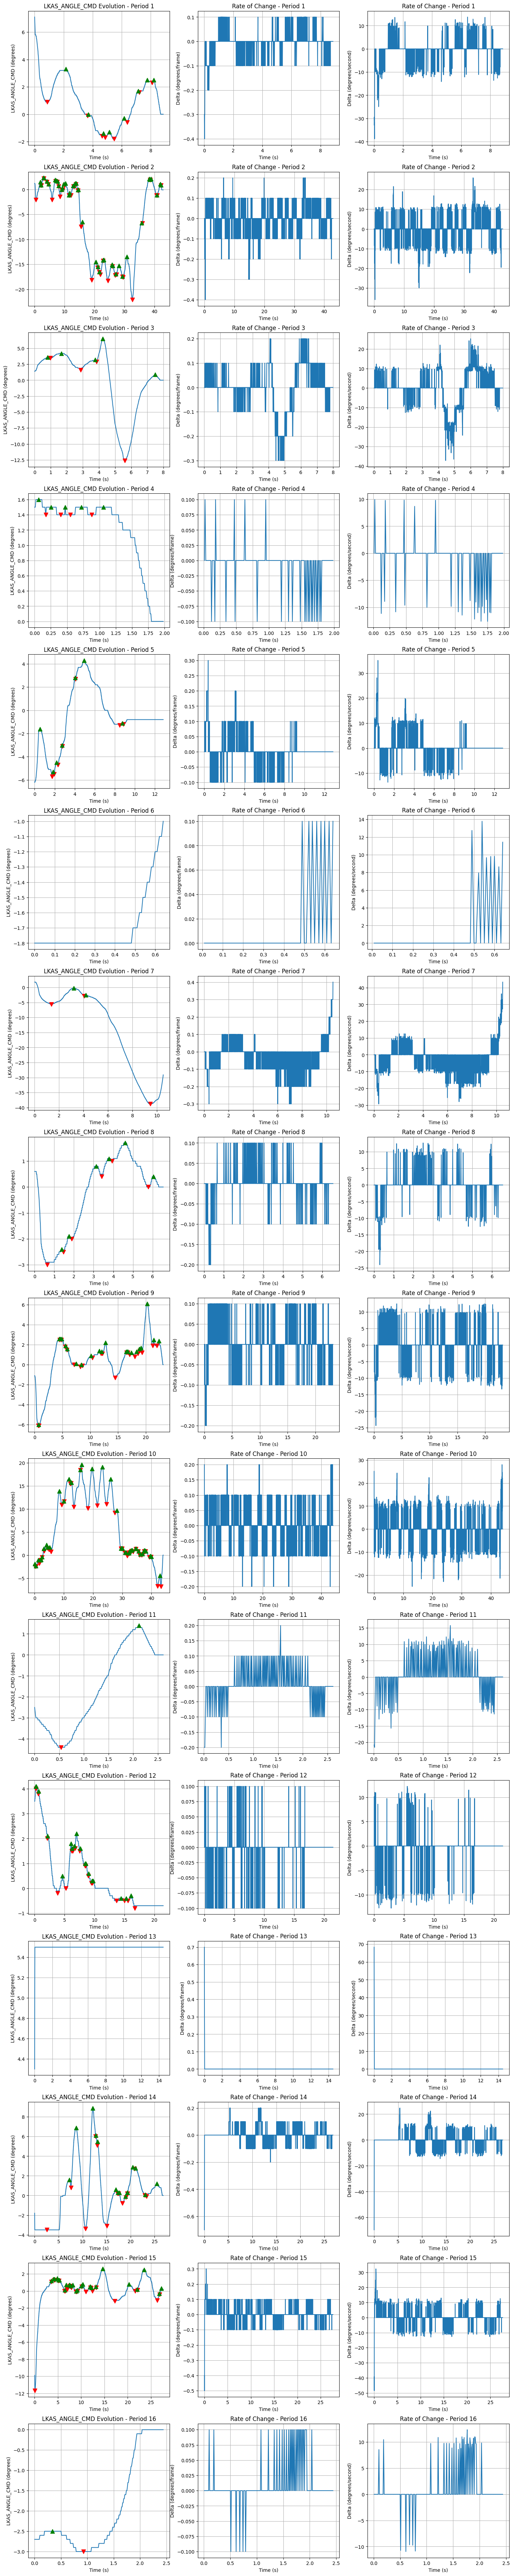

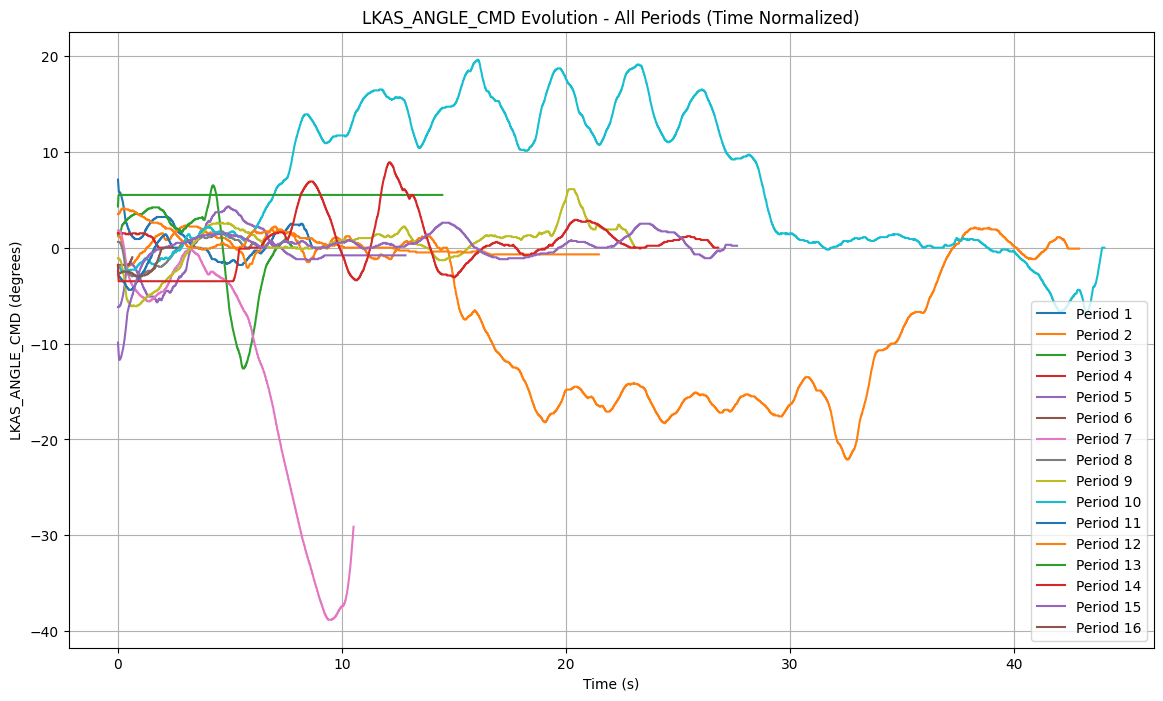

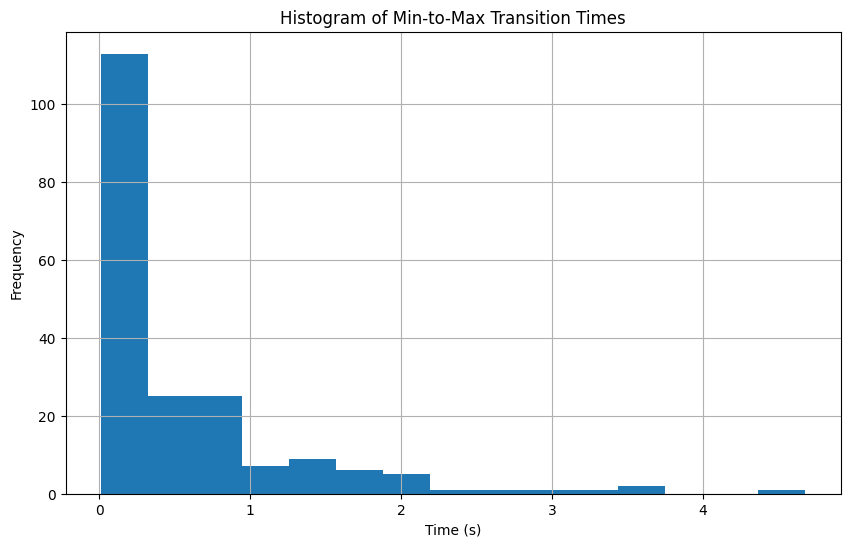

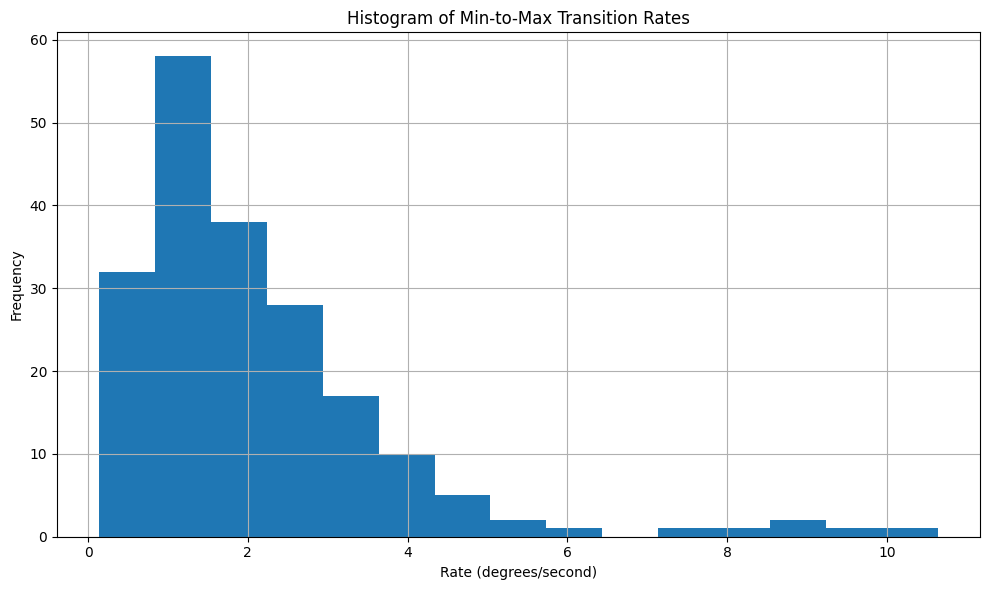

In [33]:
# Analyze all active periods with enhanced metrics
if active_periods:
    # Initialize variables to track overall statistics
    all_max_rates_per_frame = []
    all_max_rates_per_second = []
    all_min_to_max_times = []
    all_min_to_max_rates = []
    
    # Create a figure with subplots for all periods
    num_periods = len(active_periods)
    fig, axes = plt.subplots(num_periods, 3, figsize=(18, 6*num_periods))
    
    # If there's only one period, make axes indexable as a 2D array
    if num_periods == 1:
        axes = np.array([axes]).reshape(1, 3)
    
    # Process each active period
    for i, (start_idx, end_idx) in enumerate(active_periods):
        # Get data for this period
        period_timestamps = timestamps[start_idx:end_idx+1]
        period_angle_cmds = angle_cmds[start_idx:end_idx+1]
        
        # Normalize timestamps to start at 0
        norm_timestamps = [t - period_timestamps[0] for t in period_timestamps]
        
        # Calculate rate of change per frame
        angle_cmd_diffs = np.diff(period_angle_cmds)
        max_rate_per_frame = max(abs(angle_cmd_diffs))
        all_max_rates_per_frame.append(max_rate_per_frame)
        
        # Calculate rate of change per second
        time_diffs = np.diff(period_timestamps)
        rates_per_second = [diff/t_diff if t_diff > 0 else 0 for diff, t_diff in zip(angle_cmd_diffs, time_diffs)]
        max_rate_per_second = max(abs(rate) for rate in rates_per_second)
        all_max_rates_per_second.append(max_rate_per_second)
        
        # Find local minima and maxima
        from scipy.signal import find_peaks
        
        # Find local maxima
        max_peaks, _ = find_peaks(period_angle_cmds)
        # Find local minima (by finding maxima of negative values)
        min_peaks, _ = find_peaks([-x for x in period_angle_cmds])
        
        min_to_max_times = []
        min_to_max_rates = []
        
        # For each minimum, find the next maximum and calculate metrics
        for min_idx in min_peaks:
            # Find the next maximum after this minimum
            next_max_indices = [idx for idx in max_peaks if idx > min_idx]
            if next_max_indices:  # If there's a maximum after this minimum
                next_max_idx = next_max_indices[0]
                
                # Time from min to max
                time_diff = period_timestamps[next_max_idx] - period_timestamps[min_idx]
                
                # Change in angle
                angle_diff = period_angle_cmds[next_max_idx] - period_angle_cmds[min_idx]
                
                # Rate of change
                rate = angle_diff / time_diff if time_diff > 0 else 0
                
                min_to_max_times.append(time_diff)
                min_to_max_rates.append(rate)
        
        if min_to_max_times:  # If we found min-to-max transitions
            avg_min_to_max_time = sum(min_to_max_times) / len(min_to_max_times)
            avg_min_to_max_rate = sum(min_to_max_rates) / len(min_to_max_rates)
            max_min_to_max_rate = max(abs(rate) for rate in min_to_max_rates)
            
            all_min_to_max_times.extend(min_to_max_times)
            all_min_to_max_rates.extend(min_to_max_rates)
        else:
            avg_min_to_max_time = 0
            avg_min_to_max_rate = 0
            max_min_to_max_rate = 0
        
        # Print statistics for this period
        print(f"Analysis of Period {i+1}:")
        print(f"  Duration: {period_timestamps[-1] - period_timestamps[0]:.2f}s")
        print(f"  Points: {len(period_angle_cmds)}")
        print(f"  Angle range: {min(period_angle_cmds):.2f} to {max(period_angle_cmds):.2f}")
        print(f"  Max absolute rate of change: {max_rate_per_frame:.2f} degrees/frame")
        print(f"  Max absolute rate of change: {max_rate_per_second:.2f} degrees/second")
        if min_to_max_times:
            print(f"  Avg time from min to max: {avg_min_to_max_time:.2f}s")
            print(f"  Avg rate from min to max: {avg_min_to_max_rate:.2f} degrees/second")
            print(f"  Max rate from min to max: {max_min_to_max_rate:.2f} degrees/second")
        print()
        
        # Plot angle commands
        axes[i, 0].plot(norm_timestamps, period_angle_cmds)
        # Add markers for mins and maxs
        for min_idx in min_peaks:
            axes[i, 0].plot(norm_timestamps[min_idx], period_angle_cmds[min_idx], 'rv', markersize=8)
        for max_idx in max_peaks:
            axes[i, 0].plot(norm_timestamps[max_idx], period_angle_cmds[max_idx], 'g^', markersize=8)
            
        axes[i, 0].set_title(f"LKAS_ANGLE_CMD Evolution - Period {i+1}")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("LKAS_ANGLE_CMD (degrees)")
        axes[i, 0].grid(True)
        
        # Plot rate of change per frame
        axes[i, 1].plot(norm_timestamps[1:], angle_cmd_diffs)
        axes[i, 1].set_title(f"Rate of Change - Period {i+1}")
        axes[i, 1].set_xlabel("Time (s)")
        axes[i, 1].set_ylabel("Delta (degrees/frame)")
        axes[i, 1].grid(True)
        
        # Plot rate of change per second
        axes[i, 2].plot([norm_timestamps[j] for j in range(1, len(norm_timestamps))], rates_per_second)
        axes[i, 2].set_title(f"Rate of Change - Period {i+1}")
        axes[i, 2].set_xlabel("Time (s)")
        axes[i, 2].set_ylabel("Delta (degrees/second)")
        axes[i, 2].grid(True)
    
    # Calculate overall statistics
    avg_max_rate_per_frame = sum(all_max_rates_per_frame) / len(all_max_rates_per_frame)
    avg_max_rate_per_second = sum(all_max_rates_per_second) / len(all_max_rates_per_second)
    
    print("\nOverall Statistics:")
    print(f"Average maximum rate of change: {avg_max_rate_per_frame:.2f} degrees/frame")
    print(f"Average maximum rate of change: {avg_max_rate_per_second:.2f} degrees/second")
    
    if all_min_to_max_times:
        avg_min_to_max_time = sum(all_min_to_max_times) / len(all_min_to_max_times)
        avg_min_to_max_rate = sum(all_min_to_max_rates) / len(all_min_to_max_rates)
        max_min_to_max_rate = max(abs(rate) for rate in all_min_to_max_rates)
        
        print(f"Average time from min to max: {avg_min_to_max_time:.2f}s")
        print(f"Average rate from min to max: {avg_min_to_max_rate:.2f} degrees/second")
        print(f"Maximum rate from min to max: {max_min_to_max_rate:.2f} degrees/second")
    
    # Add a summary section with all periods on one plot
    plt.figure(figsize=(14, 8))
    
    # Plot all periods with different colors
    for i, (start_idx, end_idx) in enumerate(active_periods):
        period_timestamps = timestamps[start_idx:end_idx+1]
        period_angle_cmds = angle_cmds[start_idx:end_idx+1]
        norm_timestamps = [t - period_timestamps[0] for t in period_timestamps]
        
        plt.plot(norm_timestamps, period_angle_cmds, label=f"Period {i+1}")
    
    plt.title("LKAS_ANGLE_CMD Evolution - All Periods (Time Normalized)")
    plt.xlabel("Time (s)")
    plt.ylabel("LKAS_ANGLE_CMD (degrees)")
    plt.grid(True)
    plt.legend()
    
    # Create a histogram of min-to-max times
    if all_min_to_max_times:
        plt.figure(figsize=(10, 6))
        plt.hist(all_min_to_max_times, bins=15)
        plt.title("Histogram of Min-to-Max Transition Times")
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency")
        plt.grid(True)
        
        # Create a histogram of min-to-max rates
        plt.figure(figsize=(10, 6))
        plt.hist(all_min_to_max_rates, bins=15)
        plt.title("Histogram of Min-to-Max Transition Rates")
        plt.xlabel("Rate (degrees/second)")
        plt.ylabel("Frequency")
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Also display the original figure with individual period plots
    fig.tight_layout()
    plt.show()
else:
    print("No active periods found to analyze")